# NYC Taxi Data

In August 2015, the NYC Taxi and Limosine Commission released taxi data up through June 2015. 
This project analyzes some of that data, which is available at: 
    http://www.nyc.gov/html/tlc/html/about/trip_record_data.shtml

In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import rcParams 
import pickle
import os

## Getting and Checking the Data

In [2]:
# Read in the data. We'll just start with the data for June, 2015, for  yellow cabs.
yellowDF = pd.read_csv('Data/yellow_tripdata_2015-06.csv')

print yellowDF.shape

(12332380, 18)


Just the data in June gives us over 12 million records. We don't need all 18 columns, but we'll leave them for now. However, it might be nice to clean up the labels a bit. Then we'll need to clean the data to remove anything that won't help us, like NaNs, trips that take zero time, or those that clearly have incorrect entries.

In [3]:
labels = ['VendorID', 'pickup_time', 'dropoff_time', 'passenger_count', 'distance', 'pickup_long', 'pickup_lat', 
         'RateCodeID', 'flag', 'dropoff_long', 'dropoff_lat', 'payment_type', 'fare', 'extra', 'mta_tax',
         'tip', 'tolls', 'total']
yellowDF.columns = labels

In [5]:
# Let's get the summary of this dataframe to get an idea of what we have. 
# Then we'll just print out some of the values of interest.
yellowDF.describe().loc[['min','max'],['passenger_count', 'distance', 'pickup_long', 'pickup_lat', 
                                       'dropoff_long', 'dropoff_lat', 'total']]

,passenger_count,distance,pickup_long,pickup_lat,dropoff_long,dropoff_lat,total
min,0,0,-759.233337,-67.136963,-754.166687,-16.177874,-300.00
max,9,10083318,149.028534,69.702576,125.535568,483.450012,335414.49


Uh oh. Looks like there are some wacky values here. A longitude of -759.23 goes around the Earth twice, then ends up somewhere in the Atlantic Ocean. And the range for the pickup latitude is far too great. In the next section, we'll clean up the data so we remove the entries that don't make sense. 

## Cleaning the Data

Here's what we'd like to get rid of:
* Trips that take zero time or have zero distance
* Trips that take many hours or have distances more than 100 miles
* Trips that start or end far outside of New York City
* Fares that are below zero, or far above anything reasonable

In [6]:
# Remove any rows that include NaNs.
yellowDF = yellowDF.dropna()

# Remove distances less than zero or over 100 miles
yellowDF = yellowDF[(yellowDF.distance > 0) & (yellowDF.distance < 100)]

# Only get trips in NYC
yellowDF = yellowDF[(yellowDF.pickup_long >= -74.1) & (yellowDF.pickup_long <= -73.7) & \
                   (yellowDF.dropoff_long >= -74.1) & (yellowDF.dropoff_long <= -73.7) & \
                   (yellowDF.pickup_lat >= 40.6) & (yellowDF.pickup_lat <= 41.0) & \
                   (yellowDF.dropoff_lat >= 40.6) & (yellowDF.dropoff_lat <= 41.0)]

# Remove trips with total fares less than zero or more than $200. (Yes, 
# it's possible to spend more on a cab ride in NYC, but some of those were for 
# short trips, so they seem like bad data.)
yellowDF = yellowDF[(yellowDF.total > 0) & (yellowDF.total < 200)]

Part of our analysis will concern the difference between the pickup and dropoff times. For this, we first need to convert the date-time strings into datetime objects. Then it would be helpful to remove trips that took zero time, since those will only mess up our calculations.

In [7]:
# Convert times to datetime objects.
yellowDF['pickup_time'] = pd.to_datetime(yellowDF['pickup_time'])
yellowDF['dropoff_time'] = pd.to_datetime(yellowDF['dropoff_time'])

# Remove all trips that are 0 seconds in length.
trip_duration = yellowDF['dropoff_time'] - yellowDF['pickup_time']
yellowDF = yellowDF[trip_duration > 0]

At this point, we've removed 293,497 records, which is only about 2.4% of the original data.

## Analyzing the Data

Here are some questions we can answer about the data for June 2015:
- What is the mean fare per minute driven?
- What is the median of the taxi's fare per mile driven?
- What is the taxi's average driving speed in miles per hour?
- What is the average ratio of the distance between the pickup and dropoff divided by the distance driven?
- What is the distribution of rides by hour of the day?

### 1) What is the mean fare per minute driven?

In [9]:
# Convert the trip duration series to seconds, divide by 60 to get minutes,
# divide the fare by that result, then take the mean.
avg_fare_per_minute = np.mean(yellowDF['fare']/(np.divide(trip_duration, np.timedelta64(1,'s'))/60))
print('$%2.2f per minute' % avg_fare_per_minute)

$1.09 per minute


### 2) What is the median of the taxi's fare per mile driven?

In [10]:
# Divide the fare by the distance, then get the median.
med_per_mile = np.median(yellowDF['fare']/yellowDF['distance'])
print('$%2.2f per mile' % med_per_mile)

$5.33 per mile


### 3) What is the taxi's average driving speed in miles per hour?

In [12]:
# First get the duration of each trip, in hours, then divide the distance
# driven by the duration to get the average speed of each trip.
duration_in_hours = np.divide(trip_duration, np.timedelta64(1,'s'))/3600
speed = yellowDF['distance']/duration_in_hours

# Note that if we look at np.sum(speed>100), we see there are 8,115 trips where
# the speed exceeded 80 miles per hour! Let's consider that bad data and remove those.
speed = speed[speed < 80]

print('%2.2f miles per hour' % np.mean(speed))

11.69 miles per hour


### 4) What is the average ratio of the distance between the pickup and dropoff divided by the distance driven?

In [13]:
# We first need to get the distance in miles between the pickup and dropoff
# locations based on latitude and longitude, ignoring the curvature of the Earth.

# Note that each 0.00001 degree longitude = 1.1132m, but 0.00001 degrees 
# latitude = 0.787m at 45 deg. N [http://en.wikipedia.org/wiki/Decimal_degrees]  
# NYC is about 40 deg N, so we'll use the 0.787m figure.

x = (yellowDF['dropoff_long'] - yellowDF['pickup_long'])* 100000 * 0.787
y = (yellowDF['dropoff_lat'] - yellowDF['pickup_lat'])* 100000 * 1.1132
dist = np.sqrt(x*x + y*y)/1609.34 # Convert from meters to miles

print('Avg driving distance: %2.2f miles' % np.mean(yellowDF['distance']))
print('Avg distance traveled: %2.2f miles' % np.mean(dist))

Avg driving distance: 2.99 miles
Avg distance traveled: 2.09 miles


It's reasonable that the distance driven is on average greater than the Euclidian distance traveled. However, before we can get the final answer, we need to consider that there are 41,010 trips where the start and end points are the same, i.e., the distance traveled was zero, even if the driving distance wasn't. Perhaps the passenger had the cab return them to the same spot after performing some errand. We don't know. 

This represents about 0.3% of the data, so it probably won't affect the outcome much. However, we still have to look for records where the driving distance is less than the Euclidian distance traveled, since the straight-line distance should always be the shortest distance. We find 418,271 records where this is the case, so let's remove those before getting our final ratio.

In [14]:
# Remove trips where driving distance < Euclidian distance
yellowDF = yellowDF[(yellowDF['distance'] - dist) >= 0]
dist = dist[(yellowDF['distance'] - dist) >= 0]

print('Avg driving distance: %2.2f miles' % np.mean(yellowDF['distance']))
print('Avg distance traveled: %2.2f miles' % np.mean(dist))
print('Avg ratio of distance traveled to distance driven: %2.2f ' % np.mean(dist/yellowDF['distance']))

Avg driving distance: 3.06 miles
Avg distance traveled: 2.13 miles
Avg ratio of distance traveled to distance driven: 0.74 


### 5) What is the distribution of rides by hour of the day?

In [27]:
# Create series of the total number of rides grouped by hour of the day.
yellowDF['hour'] = yellowDF.pickup_time
yellowDF['hour'] = yellowDF['hour'].apply(lambda x: x.hour)
hourly_rides = yellowDF.groupby(['hour']).count()['VendorID']

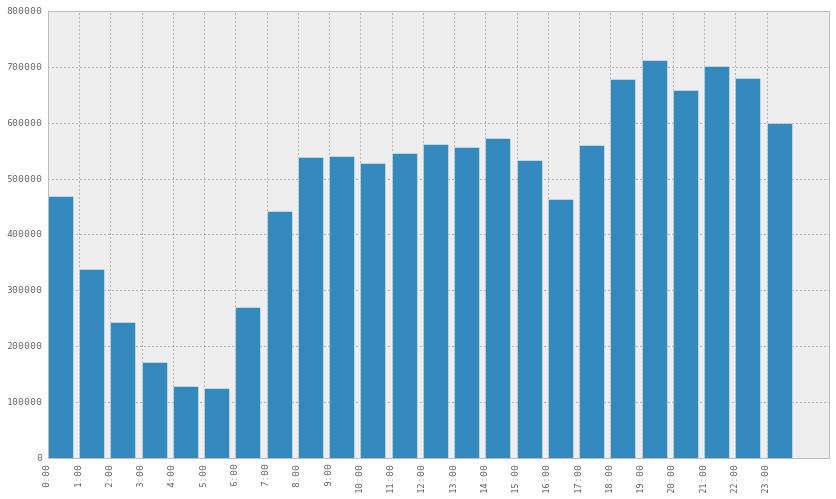

In [44]:
%matplotlib inline

pd.options.display.mpl_style = 'default'
rcParams['figure.figsize'] = (14, 8) # Figure size in inches

fig = plt.figure()
ax = plt.subplot(111)
ax.bar(hourly_rides.index, hourly_rides.values)
ax.set_xticks(hourly_rides.index)
ax.set_xticklabels(['0:00','1:00','2:00','3:00','4:00','5:00',
                    '6:00','7:00','8:00','9:00','10:00','11:00',
                    '12:00','13:00','14:00','15:00','16:00','17:00',
                    '18:00','19:00','20:00','21:00','22:00','23:00'], rotation=90)
plt.show()

We see a steady drop in cab rides starting at about 11:00 p.m., until about 5:00 a.m., when there's a rapid rise as the day starts for most people in the city.

## Visualizing the Pickup and Dropoff Locations

Time to make a nice visualization of where the taxis make their rounds. We'll first try a basic graph, then refine it with a more sophisticated approach.

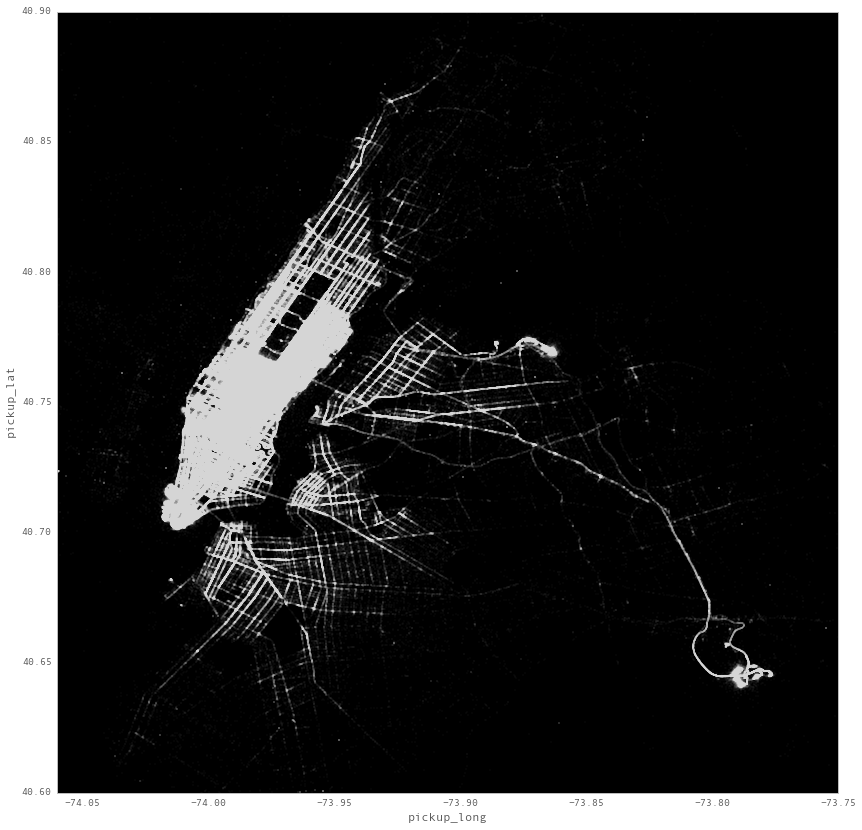

In [15]:
%matplotlib inline

pd.options.display.mpl_style = 'default'
rcParams['figure.figsize'] = (14, 14) # Figure size in inches
rcParams['figure.dpi'] = 250

# Just get the pickup locations, then plot those as a scatter plot.
pickup = yellowDF.loc[:, ['pickup_long', 'pickup_lat']]
Taxi_pickup = pickup.plot(kind='scatter', x='pickup_long', y='pickup_lat', color='white',
              xlim=(-74.06,-73.75), ylim=(40.6, 40.9), s=.01, alpha=.5)

Taxi_pickup.set_axis_bgcolor('black') # Make the background black

This is a good start. Unfortunately, there's a lot more activity downtown, so that area is saturated with points. We need to refine the image. 

Rather than make a scatter plot from the dataframe, we can create an array where each cell represents a latitude and longitude value. We increment each cell based on the number of taxi trips that began or ended there. To even out the values, we can take the logarithm, so that the outlying areas show up nearly as well as the downtown area. We then create an image from that revised array.

In [16]:
# Create a dataframe of just the pickup and dropoff data
trip = yellowDF.loc[:, ['pickup_long', 'pickup_lat', 'dropoff_long', 'dropoff_lat']]

In [17]:
# Normalize the values so they fall between 0 and 3999, which are the limits of the indices of 
# the 4000 x 4000 image we'll create.
trip.pickup_long = trip.pickup_long - min(trip.pickup_long)
trip.pickup_lat = trip.pickup_lat - min(trip.pickup_lat)
trip.dropoff_long = trip.dropoff_long - min(trip.dropoff_long)
trip.dropoff_lat = trip.dropoff_lat - min(trip.dropoff_lat)

trip = np.round(trip*9997, 0)

trip.describe().loc[['count','min','max'],:]

,pickup_long,pickup_lat,dropoff_long,dropoff_lat
count,11620612,11620612,11620612,11620612
min,0,0,0,0
max,3996,3990,3999,3995


In [20]:
# Initialize a 2-D array of ones. We use ones here instead of zeros because we'll be taking the 
# log of the final values later, and we can't take the log of zero.
array_vals = np.ones((4000,4000))

# For every pickup or dropoff location that matches an array location, increment the value
# of that element. Each element represents a pixel of the final image.
# Note that the y-values (the latitudes) need to be reversed, ie, subtracted from 3999.
def incr_ar(row):
    array_vals[3999-row['pickup_lat'], row['pickup_long']] += 1
    array_vals[3999-row['dropoff_lat'], row['dropoff_long']] += 1
    
t = trip.apply(incr_ar, axis=1)

# Take the log of the values.
log_vals10 = np.log(array_vals)

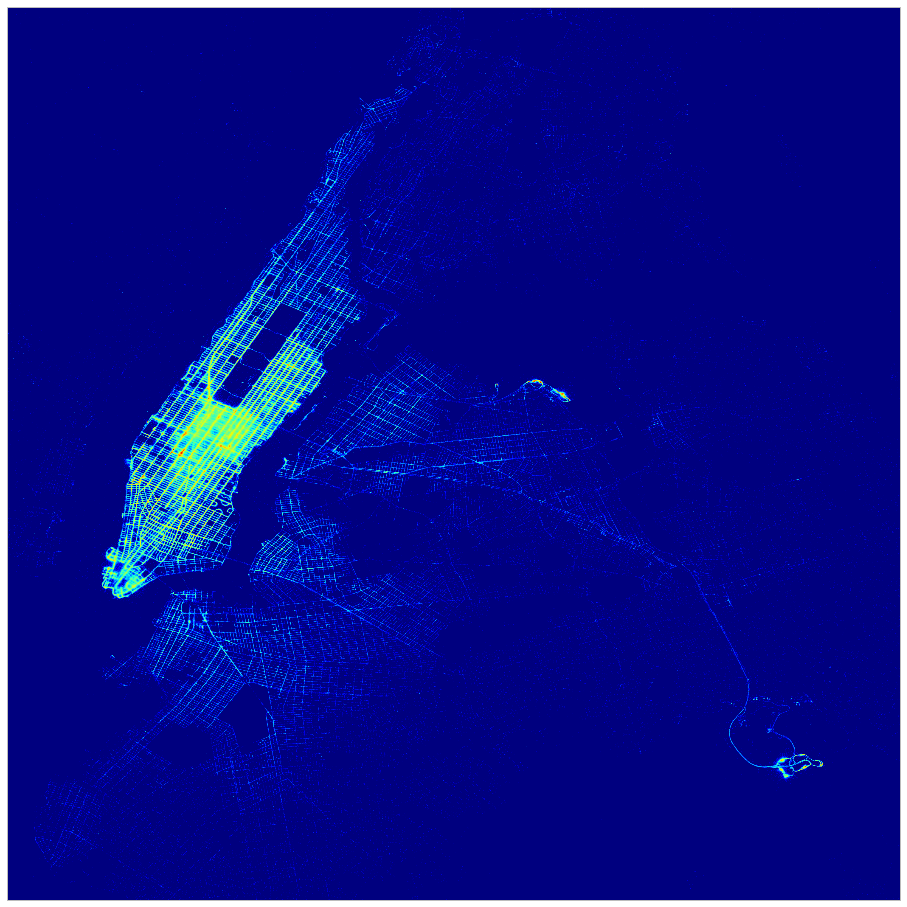

In [21]:
%matplotlib inline

pd.options.display.mpl_style = 'default'

# # This creates a figure that is 4000 x 4000 pixels
rcParams['figure.figsize'] = (16, 16) # Figure size in inches
rcParams['figure.dpi'] = 250

# Create, save, and show the image
fig = plt.imshow(log_vals10[1000:4000, 500:3500]) # For just downtown use [1500:3000, 700:2200]
fig.axes.get_xaxis().set_visible(False)
fig.axes.get_yaxis().set_visible(False)
plt.savefig('NYC_Cabs.png', dpi=250, pad_inches=0, bbox_inches='tight')
plt.show()


This is looking much cleaner! Since we only have one month of data, I included both the pickup and dropoff locations. Otherwise, the image would have been too light. Still, the city and the airport show up quite well, but for a more complete picture we'd use data from several months, or an entire year.